In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn import init

from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

from tqdm import tqdm, trange
from einops import rearrange
import scipy
import random
from path import Path

In [2]:
# for reproducibility
RANDOM_SEED = 10
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### creating positional embedding

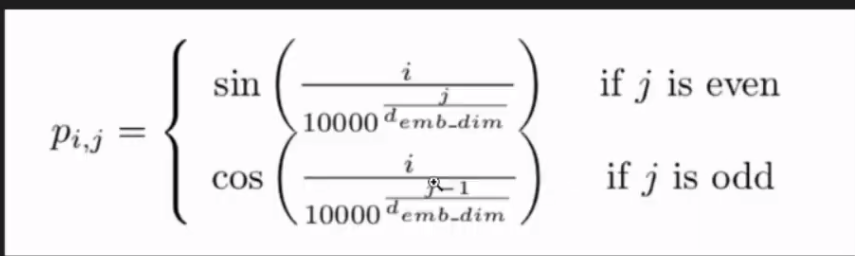

- Usually the positional embedding is given by above formuales, there is no clear explanation for why 10000 is chosen, we will try to construct positional embedding inspired by above formulation but in a bit more methodical way. See below

### Designing non learnable positional embedding
- we want embedding of nearby token to be closer as compared to far away tokens
- positional embedding should be independent of sequence length

Below, we think of sequence as frequency dimension where each token in sequence is vibrating with linearly increasing frequency in higher dimensional space (denoted by dim_), so higher dimensional space is akin to time dimension. If we make dim_ > 16*embedding dimension of token, then we get the above desired property

In [49]:
seq_length = 16 # think of this dimension as frequency
dim = 32 # think of this dimension as time
dim_= 16*dim

t = np.arange(0,dim//2)
seq_freq = np.arange(0,seq_length)/dim_
# create freq signal per sequence token
sig = [np.exp(1j*2*np.pi*freq*t) for freq in seq_freq]
sig = np.array(sig)
sig_real = sig.real
sig_imag = sig.imag
sig = np.hstack((sig_real, sig_imag))
print(sig.shape, sig_real.shape, sig_imag.shape, dim_)
# compute eucledian pairwise distance
dist_eucl = scipy.spatial.distance.pdist(sig, metric='euclidean')
dist_eucl = scipy.spatial.distance.squareform(dist_eucl, force='no', checks=True)
# compute cosine pairwise distance
dist_cosine = scipy.spatial.distance.pdist(sig, metric='cosine')
dist_cosine = scipy.spatial.distance.squareform(dist_cosine, force='no', checks=True)

(16, 32) (16, 16) (16, 16) 512


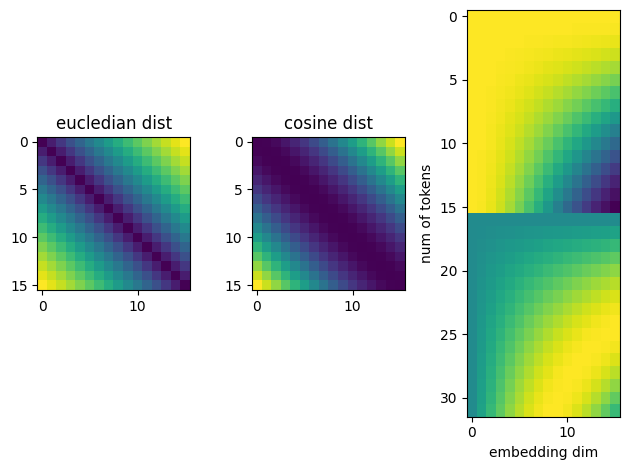

In [59]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(dist_eucl)
ax[1].imshow(dist_cosine)
ax[2].imshow(sig.T, aspect='auto')
ax[2].set_xlabel("embedding dim")
ax[2].set_ylabel("num of tokens")
ax[0].set_title("eucledian dist")
ax[1].set_title("cosine dist")
fig.tight_layout()

- Now you can see that this fixed positional encoding has desired cosine/eucledian distance behaviour
- But, one visual problem, if you stack real and imaginary part, the visual pattern shows a discontinuity. I dont think that's a problem as we already have our desired property

- Another way is to think of sequence as time dimension and embedding dim as frequency. Each embedding dimension has linearly increasing frequency vibrating in a higher dimensional space along sequence dimension

In [6]:
seq_length = 16 # think of this dimension as time
dim = 32 # think of this dimension as frequency
dim_= 32*seq_length

t = np.arange(0,seq_length//2)
dim_freq = np.arange(0,dim)/dim_
# create freq signal per sequence token
sig = [np.exp(1j*2*np.pi*freq*t) for freq in dim_freq]
sig = np.array(sig)
sig_real = sig.real
sig_imag = sig.imag
sig = np.hstack((sig_real, sig_imag))
print(sig.shape, sig_real.shape, sig_imag.shape, dim_)
# compute eucledian pairwise distance
dist_eucl = scipy.spatial.distance.pdist(sig.T, metric='euclidean')
dist_eucl = scipy.spatial.distance.squareform(dist_eucl, force='no', checks=True)
# compute cosine pairwise distance
dist_cosine = scipy.spatial.distance.pdist(sig.T, metric='cosine')
dist_cosine = scipy.spatial.distance.squareform(dist_cosine, force='no', checks=True)

(32, 16) (32, 8) (32, 8) 512


Text(0.5, 1.0, 'cosine dist')

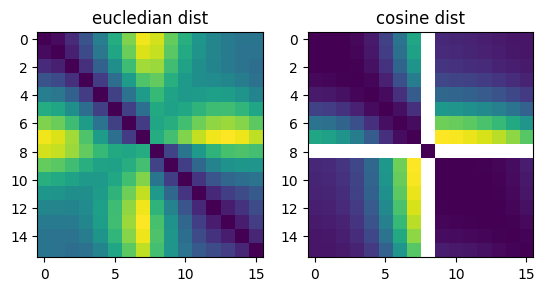

In [7]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(dist_eucl)
ax[1].imshow(dist_cosine)
ax[0].set_title("eucledian dist")
ax[1].set_title("cosine dist")

- As we can see above, if we construct the positional embedding by assuming each embedding dimension as linearly increasing frequency and use both cosines and sine, we can see we do not get desired distance property (across each row, the distance decrease between adjacent token and then starts increasing
- One way to fix this is to essentially just take cosine embedding (instead of cosine and sine). see below

In [8]:
seq_length = 16 # think of this dimension as time
dim = 32 # think of this dimension as frequency
dim_= 64*seq_length

t = np.arange(0,seq_length)
dim_freq = np.arange(0,dim)/dim_
# create freq signal per sequence token
sig = [np.cos(2*np.pi*freq*t) for freq in dim_freq]
sig = np.array(sig)
print(sig.shape, dim_)
# compute eucledian pairwise distance
dist_eucl = scipy.spatial.distance.pdist(sig.T, metric='euclidean')
dist_eucl = scipy.spatial.distance.squareform(dist_eucl, force='no', checks=True)
# compute cosine pairwise distance
dist_cosine = scipy.spatial.distance.pdist(sig.T, metric='cosine')
dist_cosine = scipy.spatial.distance.squareform(dist_cosine, force='no', checks=True)

(32, 16) 1024


Text(0.5, 1.0, 'cosine dist')

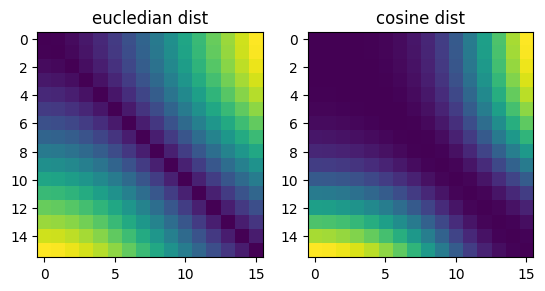

In [9]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(dist_eucl)
ax[1].imshow(dist_cosine)
ax[0].set_title("eucledian dist")
ax[1].set_title("cosine dist")

### Encoder layers

In [4]:
class MultiHead(nn.Module):
    def __init__(self, n_heads, embed_size, block_size, dropout):
        super().__init__()
        assert embed_size % n_heads == 0
        self.head_size = embed_size // n_heads
        # key, query, values for all heads but in batch
        self.c_attn = nn.Linear(embed_size, 3*embed_size)
        # output projection from forking path to residual highway
        self.proj = nn.Linear(embed_size, embed_size)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.residual_dropout = nn.Dropout(dropout)
        
        self.n_heads = n_heads

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_heads*self.head_size, dim=2) # B, T, C(=n_heads*head_size)
        # create multi-head
        q = rearrange(q, 'b t (nh c) -> b nh t c', nh=self.n_heads) # B, nh, T, head_size
        k = rearrange(k, 'b t (nh c) -> b nh c t', nh=self.n_heads) # B, nh, head_size, T
        v = rearrange(v, 'b t (nh c) -> b nh t c', nh=self.n_heads) # B, nh, T, head_size
        attn = (q @ k)* self.head_size**(-0.5) #B,nh,T,T
        attn = F.softmax(attn, dim=-1) #B,nh,T,T
        attn = self.attn_dropout(attn)
        y = attn @ v # B,nh,T,T * B,nh,T,head_size -> B,nh,T,head_size
        y = rearrange(y, 'b nh t hs -> b t (nh hs)', nh=self.n_heads) # B, T, nh*head_size(=embed_size)

        # output projection onto residual pathway
        y = self.proj(y) # B, T, nh*head_size(=embed_size) -> B, T, nh*head_size(=embed_size)
        y = self.residual_dropout(y)
        return y, attn

In [5]:
class FF(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        # feed-forward
        self.ffnet = nn.Sequential(nn.Linear(embed_size, 4*embed_size),
                                   nn.ReLU(),
                                   nn.Linear(4*embed_size, embed_size)
                                  )
    def forward(self, x):
        return self.ffnet(x)


In [6]:
# Now create a Repeat module of self attention and feed-forward 
class Repeat(nn.Module):
    def __init__(self, n_heads, embed_size, block_size, dropout):
        super().__init__()
        self.sa_mhead = MultiHead(n_heads, embed_size, block_size, dropout) # self attention multihead
        self.ffwd = FF(embed_size)
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        x = self.ln1(x)
        sa_mheadop, attn = self.sa_mhead(x)
        x = x + sa_mheadop
        x = self.ln2(x)
        x = x + self.ffwd(x)
        return x, attn
    

### Patch Embedding

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, embed_size, inchannels, img_size, dropout):
        '''
        assume image is square size
        patch is also square size
        '''
        super().__init__()
        self.patch_size = patch_size
        self.embedding_size = embed_size
        self.inchannels = inchannels
        self.img_size = img_size

        assert self.img_size%self.patch_size==0, "image size must be divisible by patch size"

        self.n_patches = int((self.img_size/self.patch_size)**2)
        self.patch_embeddinglayer = nn.Linear(self.inchannels*self.patch_size*self.patch_size, self.embedding_size)
        # create a dummy learnable token
        self.cls = nn.Parameter(torch.randn(1,self.embedding_size), requires_grad=True)
        # create a learnable position encoding
        self.posencoding = nn.Parameter(torch.randn(1,self.n_patches+1,self.embedding_size), requires_grad=True)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # patchify the input
        x = rearrange(x, 'b c (h h1) (w w1) -> b (h w) (c h1 w1)', h1=self.patch_size, w1=self.patch_size) #<b num_patches channel*patch_size*patch_size>
        # pass the patches through patch embedding layer
        x = self.patch_embeddinglayer(x)  #<b num_patches embedding_size>
        # concat the dummy token in front
        cls_token = self.cls.expand(x.shape[0],-1,-1) #<b 1 self.embedding_size>
        #print(x.shape, cls_token.shape)
        x = torch.cat([cls_token, x], dim=1)
        # add learned positional encoding
        x = x + self.posencoding
        x = self.dropout(x)
        return x #<b num_patches channel*patch_size*patch_size>

In [8]:
patch_size = 7
x = torch.randn(4,1,14*patch_size,14*patch_size).to(device)
embedding_size = 128
inchannels = 1
img_size = 14*patch_size
dropout = 0.1
patchembedding = PatchEmbedding(patch_size, embedding_size, inchannels, img_size, dropout).to(device)
y = patchembedding(x)
y.shape, y.device

(torch.Size([4, 197, 128]), device(type='cuda', index=0))

In [9]:
class VIT(nn.Module):
    def __init__(self, patch_size, embed_size, inchannels, img_size, dropout, n_repeat, n_heads, num_classes):
        super().__init__()
        self.block_size = int((img_size/patch_size)**2) + 1 # number of patches, +1 for additional cls token
        self.PatchEmbedd = PatchEmbedding(patch_size, embed_size, inchannels, img_size, dropout)
        # this is transformer block repeated n_repeat times
        self.stackedtransformer_encoder = nn.Sequential(*[Repeat(n_heads, embed_size, self.block_size, dropout) for _ in range(n_repeat)])
        # classification head
        self.cls_head = nn.Sequential(
                        nn.LayerNorm(embed_size),
                        nn.Linear(embed_size, num_classes)
                        )

    def forward(self, x):
        # pass the image to be patchified and generate patch embedding
        x = self.PatchEmbedd(x) # <b, num_patches, nchannels*patch_size*2>
        # pass the embedding through stacked transformer encoder
        #x, last_attn = self.stackedtransformer_encoder(x)
        for idx, layer in enumerate(self.stackedtransformer_encoder):
            x, attn = layer(x)
            
        # classify the 0th token
        x = self.cls_head(x[:,0,:])
        return x, attn #cls_head, tansf_encoder_op #(<B, num_patches, num_classes>, <B, num_patches, embed_size>)

In [10]:
PATCH_SIZE = 7
EMBED_SIZE = 256
INCHANNELS = 1
IMG_SIZE = 28*PATCH_SIZE # because tfms are resizing the image
DROPOUT = 0.1
N_REPEAT = 4
N_HEADS = 8
NUM_CLASSES = 10
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
N_EPOCHS = 8

In [11]:
x = torch.randn(4,1,28*PATCH_SIZE,28*PATCH_SIZE).to(device)
vit = VIT(PATCH_SIZE, EMBED_SIZE, INCHANNELS, IMG_SIZE, DROPOUT, N_REPEAT, N_HEADS, NUM_CLASSES).to(device)
y, z= vit(x)
y.shape, z.shape

(torch.Size([4, 10]), torch.Size([4, 8, 785, 785]))

### Download MNIST dataset

In [12]:
root = "./data"
tfms = transforms.Compose([transforms.Resize((28*PATCH_SIZE, 28*PATCH_SIZE)),
                           transforms.ToTensor(),
                           transforms.Normalize([0.5], [0.5])
        ])
mnist_traindataset = MNIST(root=root, train=True, download=True, transform=tfms)
mnist_valdataset = MNIST(root=root, train=False, download=True, transform=tfms)

In [13]:
len(mnist_traindataset), len(mnist_valdataset)

(60000, 10000)

In [14]:
image, label = mnist_traindataset[0]

In [15]:
image

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [16]:
image.size()

torch.Size([1, 196, 196])

In [17]:
type(image)

torch.Tensor

In [18]:
# construct dataloader
trainloader = DataLoader(dataset = mnist_traindataset, 
                         batch_size = BATCH_SIZE, 
                         shuffle=True)

valloader = DataLoader(dataset = mnist_valdataset, 
                         batch_size = BATCH_SIZE, 
                         shuffle=False)

In [19]:
next(iter(trainloader))[0].shape

torch.Size([32, 1, 196, 196])

In [20]:
next(iter(trainloader))[0].dtype

torch.float32

In [21]:
# loss function, Optimizer
criterion = nn.CrossEntropyLoss()
vit = VIT(PATCH_SIZE, EMBED_SIZE, INCHANNELS, IMG_SIZE, DROPOUT, N_REPEAT, N_HEADS, NUM_CLASSES).to(device)
opt = Adam(vit.parameters(), lr=LEARNING_RATE)

In [22]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)):
        init.kaiming_normal_(m.weight)

In [23]:
vit.apply(init_weights)

VIT(
  (PatchEmbedd): PatchEmbedding(
    (patch_embeddinglayer): Linear(in_features=49, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (stackedtransformer_encoder): Sequential(
    (0): Repeat(
      (sa_mhead): MultiHead(
        (c_attn): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (residual_dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FF(
        (ffnet): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): Repeat(
      (sa_mhead): MultiHead(
        (c_attn): Linear(in_features=256, out_features=768, bias=True)
 

In [24]:
vit.PatchEmbedd.patch_embeddinglayer.weight

Parameter containing:
tensor([[ 0.2485, -0.1802,  0.0614,  ...,  0.0573, -0.0395, -0.5354],
        [ 0.0839, -0.0565, -0.2742,  ..., -0.0620, -0.2170,  0.1421],
        [ 0.2410, -0.1229, -0.0715,  ..., -0.3216,  0.1858, -0.5042],
        ...,
        [ 0.1971, -0.2053, -0.2212,  ...,  0.0571,  0.1479, -0.0257],
        [ 0.2587,  0.2128, -0.3331,  ...,  0.1689, -0.0540, -0.0677],
        [-0.4540, -0.0549, -0.1496,  ..., -0.2282, -0.1949, -0.0316]],
       device='cuda:0', requires_grad=True)

In [25]:
# just pass random noise through network before training, it seems to make it train faster
x = torch.randn(4,1,28*PATCH_SIZE,28*PATCH_SIZE).to(device)
y = vit(x)

In [131]:
outdir = Path("./")
best_val_acc = float('-inf')
for epoch in tqdm(range(N_EPOCHS), position=0, leave=True):
    vit.train()
    train_targets = []
    train_preds = []
    train_running_loss = 0
    for idx, (data, targets) in enumerate(tqdm(trainloader, position=0, leave=True)):
        # send data, label to device
        data = data.to(device)
        targets = targets.to(device)
        # get the predictions scores (logits)
        preds, _ = vit(data)
        # Next 3 lines to compute the train accuracy
        train_preds_label = torch.argmax(preds, dim=-1)
        train_preds.extend(train_preds_label.cpu().detach())
        train_targets.extend(targets.cpu().detach())
        # compute the loss
        loss = criterion(preds, targets)

        opt.zero_grad()
        loss.backward()
        opt.step()
        train_running_loss = loss.item()

    train_loss = train_running_loss/(idx+1)

    vit.eval()
    val_targets = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, (data, targets) in enumerate(tqdm(valloader, position=0, leave=True)):
            # send data, label to device
            data = data.to(device)
            targets = targets.to(device)
            # get the predictions scores (logits)
            preds,_ = vit(data)
            preds_label = torch.argmax(preds, dim=-1)
            # Next 3 lines to compute the val accuracy
            val_preds_label = torch.argmax(preds, dim=-1)
            val_preds.extend(val_preds_label.cpu().detach())
            val_targets.extend(targets.cpu().detach())
            # compute the loss
            loss = criterion(preds, targets)
    
            val_running_loss = loss.item()

    val_loss = val_running_loss/(idx+1)

    # train,val accuracy
    train_acc = np.mean(np.array(train_preds) == np.array(train_targets))
    val_acc = np.mean(np.array(val_preds) == np.array(val_targets))
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vit.state_dict(), outdir/f"modelwts_{epoch}.pth")

    print("-"*30)
    print(f"Epoch:{epoch+1}, train_loss:{train_loss}, val_loss:{val_loss}")
    print(f"Epoch:{epoch+1}, train_acc:{train_acc}, val_acc:{val_acc}")
    print("-"*30)

 12%|██████████▍                                                                        | 1/8 [08:25<58:59, 505.67s/it]

------------------------------
Epoch:1, train_loss:0.00012416027386983236, val_loss:7.205778441299646e-05
Epoch:1, train_acc:0.77605, val_acc:0.9355
------------------------------


 25%|████████████████████▊                                                              | 2/8 [17:02<51:12, 512.00s/it]

------------------------------
Epoch:2, train_loss:5.7690624396006265e-05, val_loss:2.6525498126832823e-05
Epoch:2, train_acc:0.9304666666666667, val_acc:0.9579
------------------------------


 38%|███████████████████████████████▏                                                   | 3/8 [25:40<42:54, 514.94s/it]

------------------------------
Epoch:3, train_loss:4.114557107289632e-05, val_loss:0.0006619151503133317
Epoch:3, train_acc:0.9441166666666667, val_acc:0.9633
------------------------------


 50%|█████████████████████████████████████████▌                                         | 4/8 [34:19<34:25, 516.38s/it]

------------------------------
Epoch:4, train_loss:7.752556105454762e-06, val_loss:3.4436476402008493e-05
Epoch:4, train_acc:0.9510333333333333, val_acc:0.9612
------------------------------


 62%|███████████████████████████████████████████████████▉                               | 5/8 [42:51<25:44, 514.80s/it]

------------------------------
Epoch:5, train_loss:0.00014638210932413736, val_loss:1.9557602977314695e-05
Epoch:5, train_acc:0.9563, val_acc:0.9519
------------------------------


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [51:23<17:08, 514.01s/it]

------------------------------
Epoch:6, train_loss:0.00013812975883483887, val_loss:9.283766346855666e-06
Epoch:6, train_acc:0.95765, val_acc:0.9593
------------------------------


 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [59:56<08:33, 513.76s/it]

------------------------------
Epoch:7, train_loss:6.889256636301676e-05, val_loss:2.9798537587967162e-05
Epoch:7, train_acc:0.9584666666666667, val_acc:0.9679
------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:08:32<00:00, 514.01s/it]

------------------------------
Epoch:8, train_loss:4.32361642519633e-05, val_loss:5.499460993292994e-05
Epoch:8, train_acc:0.9611833333333333, val_acc:0.9594
------------------------------


-- So our trained VIT classifier has ~98.5% accuracy on val sets, lets visualize some of the predictions

In [26]:
# empty the cuda cache
torch.cuda.empty_cache()

In [26]:
# load pre-trained weights
vit.load_state_dict(torch.load("./modelwts_6.pth"))
vit.to(device)

VIT(
  (PatchEmbedd): PatchEmbedding(
    (patch_embeddinglayer): Linear(in_features=49, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (stackedtransformer_encoder): Sequential(
    (0): Repeat(
      (sa_mhead): MultiHead(
        (c_attn): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (residual_dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FF(
        (ffnet): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): Repeat(
      (sa_mhead): MultiHead(
        (c_attn): Linear(in_features=256, out_features=768, bias=True)
 

In [27]:
with torch.no_grad():
    input_imgs = []
    preds_label = []
    target_label = []
    mha_op = [] # output of transformer encoder layer
    vit.eval()
    for idx, (data, targets) in enumerate(tqdm(valloader, position=0, leave=True)):
        if idx>50:
            break
        # send data, label to device
        data = data.to(device)
        targets = targets.to(device)
        # get the predictions scores (logits)
        preds, att = vit(data)
        preds_label.extend(torch.argmax(preds, dim=-1).cpu())
        target_label.extend(targets.cpu())
        input_imgs.extend(data.cpu())
        mha_op.extend(att.cpu())

 16%|█████████████▏                                                                   | 51/313 [01:41<08:39,  1.98s/it]


In [28]:
len(mha_op), len(input_imgs)

(1632, 1632)

In [29]:
target_label[0:5]

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4)]

In [46]:
mha_op[1631].shape

torch.Size([8, 785, 785])

In [180]:
def show_attmaps(preds, tgts, startidx=0, num_images=8, mha:list=None, npatches=None):
    preds_label_ = preds_label[startidx:startidx+num_images]
    target_label_ = target_label[startidx:startidx+num_images]
    mha_ = mha[startidx:startidx+num_images]
    cols = 4
    row = num_images // cols 
    fig, ax = plt.subplots(row, cols, sharex=True, sharey=True, figsize=(8,8))
    ridx, cidx = np.arange(0,row), np.arange(0,cols)
    axes_idx = np.array(np.meshgrid(ridx,cidx)).T.reshape(-1,2)
    for cnt,idx in enumerate(axes_idx):
        mha_map = mha_[cnt][:,0,1:] # <nheads, npatches*npatches>take the attnetion wieghts corresponding to cls token (excluding cls token itself)
        mha_map_rows = mha_map_cols = int(np.sqrt(npatches))
        mha_map = mha_map.reshape(-1,mha_map_rows,mha_map_cols)
        mha_map = mha_map.mean(axis=0) # <npatches, npatches> take mean along head dimension
        ax[idx[0],idx[1]].imshow(mha_map, aspect='auto')
        ax[idx[0],idx[1]].set_title(f"pred:{str(preds_label_[cnt].item())}, tgt:{target_label_[cnt].item()}")        
            
    fig.tight_layout()
    plt.show()

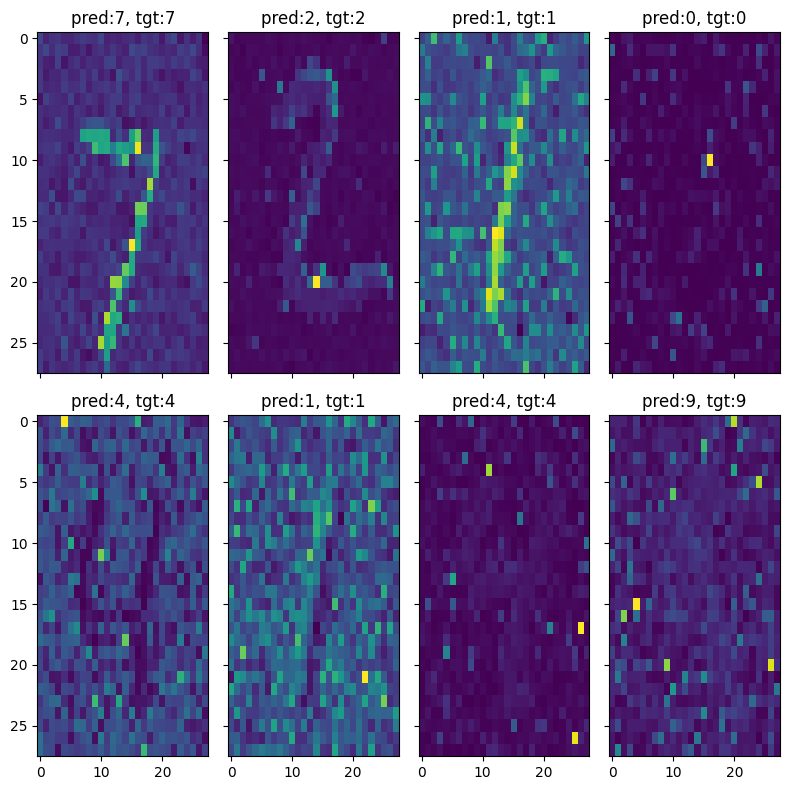

In [181]:
npatches = vit.PatchEmbedd.n_patches
show_attmaps(preds=preds_label, tgts=target_label, startidx=0, num_images=8, mha=mha_op, npatches=npatches)

In [135]:
input_imgs[0].device, preds_label[0].device, target_label[0].device

(device(type='cpu'), device(type='cpu'), device(type='cpu'))

In [182]:
def show_preds(inp_images, preds, tgts, startidx=0, num_images=16):
    inp_imgs_ = inp_images[startidx:startidx+num_images]
    preds_label_ = preds_label[startidx:startidx+num_images]
    target_label_ = target_label[startidx:startidx+num_images]
    cols = 4
    row = num_images // cols
    fig, ax = plt.subplots(row, cols, sharex=True, sharey=True, figsize=(8,8))
    ridx, cidx = np.arange(0,row), np.arange(0,cols)
    axes_idx = np.array(np.meshgrid(ridx,cidx)).T.reshape(-1,2)
    for cnt,idx in enumerate(axes_idx):
        ax[idx[0],idx[1]].imshow(inp_imgs_[cnt][0,:,:], cmap="gray", aspect='auto')
        ax[idx[0],idx[1]].set_title(f"pred:{str(preds_label_[cnt].item())}, tgt:{target_label_[cnt].item()}")
    fig.tight_layout()

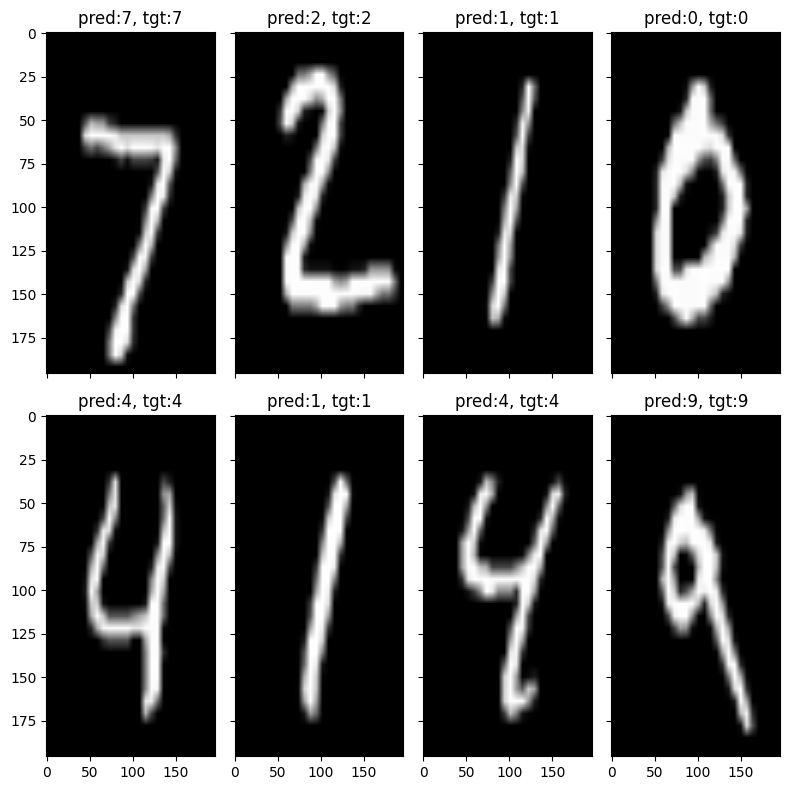

In [183]:
show_preds(input_imgs, preds_label, target_label, 0, 8)

torch.Size([1, 785, 256])


Text(0.5, 1.0, 'cosine dist')

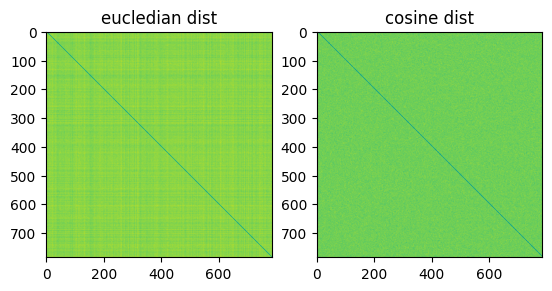

In [177]:
# check the learned positional embedding
print(vit.PatchEmbedd.posencoding.shape)
posencoding = vit.PatchEmbedd.posencoding.cpu().detach()
posencoding = np.array(posencoding).squeeze()

# compute eucledian pairwise distance
dist_eucl = scipy.spatial.distance.pdist(posencoding, metric='euclidean')
dist_eucl = scipy.spatial.distance.squareform(dist_eucl, force='no', checks=True)
# compute cosine pairwise distance
dist_cosine = scipy.spatial.distance.pdist(posencoding, metric='cosine')
dist_cosine = scipy.spatial.distance.squareform(dist_cosine, force='no', checks=True)

fig, ax = plt.subplots(1,2)
ax[0].imshow(dist_eucl)
ax[1].imshow(dist_cosine)
ax[0].set_title("eucledian dist")
ax[1].set_title("cosine dist")

- Note above that learned positional embedding does not necessarily shows that token closer have lower distance, it is non-monotic

### Lets use fixed positional encoding

(17, 256) (17, 128) (17, 128) 4096


Text(0.5, 1.0, 'cosine dist')

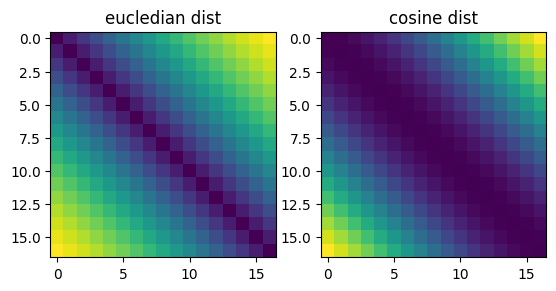

In [73]:
# design fixed positional enecoding
seq_length = 17 # think of this dimension as frequency
dim = EMBED_SIZE # think of this dimension as time
dim_= 16*dim

t = np.arange(0,dim//2)
seq_freq = np.arange(0,seq_length)/dim_
# create freq signal per sequence token
sig = [np.exp(1j*2*np.pi*freq*t) for freq in seq_freq]
sig = np.array(sig)
sig_real = sig.real
sig_imag = sig.imag
sig = np.hstack((sig_real, sig_imag))
print(sig.shape, sig_real.shape, sig_imag.shape, dim_)
# compute eucledian pairwise distance
dist_eucl = scipy.spatial.distance.pdist(sig, metric='euclidean')
dist_eucl = scipy.spatial.distance.squareform(dist_eucl, force='no', checks=True)
# compute cosine pairwise distance
dist_cosine = scipy.spatial.distance.pdist(sig, metric='cosine')
dist_cosine = scipy.spatial.distance.squareform(dist_cosine, force='no', checks=True)

# compute eucledian pairwise distance
dist_eucl = scipy.spatial.distance.pdist(sig, metric='euclidean')
dist_eucl = scipy.spatial.distance.squareform(dist_eucl, force='no', checks=True)
# compute cosine pairwise distance
dist_cosine = scipy.spatial.distance.pdist(sig, metric='cosine')
dist_cosine = scipy.spatial.distance.squareform(dist_cosine, force='no', checks=True)

fig, ax = plt.subplots(1,2)
ax[0].imshow(dist_eucl)
ax[1].imshow(dist_cosine)
ax[0].set_title("eucledian dist")
ax[1].set_title("cosine dist")

In [74]:
pos_encoding = sig
pos_encoding = torch.Tensor(pos_encoding)

In [75]:
type(pos_encoding), pos_encoding.shape

(torch.Tensor, torch.Size([17, 256]))

In [110]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, embed_size, inchannels, img_size, dropout, pos_encodingmatrix):
        '''
        assume image is square size
        patch is also square size
        '''
        super().__init__()
        self.patch_size = patch_size
        self.embedding_size = embed_size
        self.inchannels = inchannels
        self.img_size = img_size
        self.pos_encodingmatrix = pos_encodingmatrix.expand(1,-1,-1)
        

        assert self.img_size%self.patch_size==0, "image size must be divisible by patch size"

        self.n_patches = int((self.img_size/self.patch_size)**2)
        self.patch_embeddinglayer = nn.Linear(self.inchannels*self.patch_size*self.patch_size, self.embedding_size)
        # create a dummy learnable token
        self.cls = nn.Parameter(torch.randn(1,self.embedding_size), requires_grad=True)
        # create a learnable position encoding
        #self.posencoding = nn.Parameter(torch.randn(1,self.n_patches+1,self.embedding_size), requires_grad=True)
        self.posencoding = nn.Parameter(pos_encodingmatrix, requires_grad=False)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # patchify the input
        x = rearrange(x, 'b c (h h1) (w w1) -> b (h w) (c h1 w1)', h1=self.patch_size, w1=self.patch_size) #<b num_patches channel*patch_size*patch_size>
        # pass the patches through patch embedding layer
        x = self.patch_embeddinglayer(x)  #<b num_patches embedding_size>
        # concat the dummy token in front
        cls_token = self.cls.expand(x.shape[0],-1,-1) #<b 1 self.embedding_size>
        #print(x.shape, cls_token.shape)
        x = torch.cat([cls_token, x], dim=1)
        # add learned positional encoding
        x = x + self.posencoding
        x = self.dropout(x)
        return x #<b num_patches channel*patch_size*patch_size>

In [111]:
class VIT(nn.Module):
    def __init__(self, patch_size, embed_size, inchannels, img_size, dropout, n_repeat, n_heads, num_classes, pos_encodingmatrix):
        super().__init__()
        self.block_size = int((img_size/patch_size)**2) + 1 # number of patches, +1 for additional cls token
        self.PatchEmbedd = PatchEmbedding(patch_size, embed_size, inchannels, img_size, dropout, pos_encodingmatrix)
        # this is transformer block repeated n_repeat times
        self.stackedtransformer_encoder = nn.Sequential(*[Repeat(n_heads, embed_size, self.block_size, dropout) for _ in range(n_repeat)])
        # classification head
        self.cls_head = nn.Sequential(
                        nn.LayerNorm(embed_size),
                        nn.Linear(embed_size, num_classes)
                        )

    def forward(self, x):
        # pass the image to be patchified and generate patch embedding
        x = self.PatchEmbedd(x) # <b, num_patches, nchannels*patch_size*2>
        # pass the embedding through stacked transformer encoder
        x = self.stackedtransformer_encoder(x)
        # classify the 0th token
        x = self.cls_head(x[:,0,:])
        return x

In [152]:
PATCH_SIZE = 7
EMBED_SIZE = 256
INCHANNELS = 1
IMG_SIZE = 28
DROPOUT = 0.1
N_REPEAT = 8
N_HEADS = 16
NUM_CLASSES = 10
BATCH_SIZE = 512
LEARNING_RATE = 3e-4
N_EPOCHS = 20

In [153]:
# loss function, Optimizer
criterion = nn.CrossEntropyLoss()
vit = VIT(PATCH_SIZE, EMBED_SIZE, INCHANNELS, IMG_SIZE, DROPOUT, N_REPEAT, N_HEADS, NUM_CLASSES, pos_encoding).to(device)
opt = Adam(vit.parameters(), lr=LEARNING_RATE)

In [154]:
vit.apply(init_weights)

VIT(
  (PatchEmbedd): PatchEmbedding(
    (patch_embeddinglayer): Linear(in_features=49, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (stackedtransformer_encoder): Sequential(
    (0): Repeat(
      (sa_mhead): MultiHead(
        (c_attn): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (residual_dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FF(
        (ffnet): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): Repeat(
      (sa_mhead): MultiHead(
        (c_attn): Linear(in_features=256, out_features=768, bias=True)
 

In [155]:
# just pass random noise through network before training, it seems to make it train faster
x = torch.randn(4,1,28,28).to(device)
y = vit(x)

In [156]:
for epoch in tqdm(range(N_EPOCHS), position=0, leave=True):
    vit.train()
    train_targets = []
    train_preds = []
    train_running_loss = 0
    for idx, (data, targets) in enumerate(tqdm(trainloader, position=0, leave=True)):
        # send data, label to device
        data = data.to(device)
        targets = targets.to(device)
        # get the predictions scores (logits)
        preds = vit(data)
        # Next 3 lines to compute the train accuracy
        train_preds_label = torch.argmax(preds, dim=-1)
        train_preds.extend(train_preds_label.cpu().detach())
        train_targets.extend(targets.cpu().detach())
        # compute the loss
        loss = criterion(preds, targets)

        opt.zero_grad()
        loss.backward()
        opt.step()
        train_running_loss = loss.item()

    train_loss = train_running_loss/(idx+1)

    vit.eval()
    val_targets = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, (data, targets) in enumerate(tqdm(valloader, position=0, leave=True)):
            # send data, label to device
            data = data.to(device)
            targets = targets.to(device)
            # get the predictions scores (logits)
            preds = vit(data)
            preds_label = torch.argmax(preds, dim=-1)
            # Next 3 lines to compute the val accuracy
            val_preds_label = torch.argmax(preds, dim=-1)
            val_preds.extend(val_preds_label.cpu().detach())
            val_targets.extend(targets.cpu().detach())
            # compute the loss
            loss = criterion(preds, targets)
    
            val_running_loss = loss.item()

    val_loss = val_running_loss/(idx+1)

    # train,val accuracy
    train_acc = np.mean(np.array(train_preds) == np.array(train_targets))
    val_acc = np.mean(np.array(val_preds) == np.array(val_targets))

    print("-"*30)
    print(f"Epoch:{epoch+1}, train_loss:{train_loss}, val_loss:{val_loss}")
    print(f"Epoch:{epoch+1}, train_acc:{train_acc}, val_acc:{val_acc}")
    print("-"*30)

  5%|████▏                                                                              | 1/20 [00:15<04:52, 15.38s/it]

------------------------------
Epoch:1, train_loss:0.0027682201694577994, val_loss:0.0069569854796687255
Epoch:1, train_acc:0.32921666666666666, val_acc:0.6743
------------------------------


 10%|████████▎                                                                          | 2/20 [00:30<04:37, 15.41s/it]

------------------------------
Epoch:2, train_loss:0.0009693714982665169, val_loss:0.0014737769961357117
Epoch:2, train_acc:0.7670166666666667, val_acc:0.885
------------------------------


 15%|████████████▍                                                                      | 3/20 [00:46<04:23, 15.49s/it]

------------------------------
Epoch:3, train_loss:0.0004936346430768336, val_loss:0.00030018082713779016
Epoch:3, train_acc:0.8814333333333333, val_acc:0.9338
------------------------------


 20%|████████████████▌                                                                  | 4/20 [01:02<04:09, 15.57s/it]

------------------------------
Epoch:4, train_loss:0.00045858212371370684, val_loss:0.0001434882088929792
Epoch:4, train_acc:0.9135166666666666, val_acc:0.9338
------------------------------


 25%|████████████████████▊                                                              | 5/20 [01:17<03:54, 15.66s/it]

------------------------------
Epoch:5, train_loss:0.0004939350174434149, val_loss:0.0002864413670723951
Epoch:5, train_acc:0.93065, val_acc:0.9456
------------------------------


 30%|████████████████████████▉                                                          | 6/20 [01:33<03:40, 15.74s/it]

------------------------------
Epoch:6, train_loss:0.0003947103137908968, val_loss:5.700785808170898e-05
Epoch:6, train_acc:0.9418333333333333, val_acc:0.958
------------------------------


 35%|█████████████████████████████                                                      | 7/20 [01:49<03:25, 15.84s/it]

------------------------------
Epoch:7, train_loss:0.0005109508090944433, val_loss:7.948871183244489e-05
Epoch:7, train_acc:0.9467333333333333, val_acc:0.9586
------------------------------


 40%|█████████████████████████████████▏                                                 | 8/20 [02:05<03:10, 15.88s/it]

------------------------------
Epoch:8, train_loss:0.00022563381172192377, val_loss:0.0001153596617941615
Epoch:8, train_acc:0.95365, val_acc:0.9594
------------------------------


 45%|█████████████████████████████████████▎                                             | 9/20 [02:21<02:54, 15.90s/it]

------------------------------
Epoch:9, train_loss:0.0005425786667032791, val_loss:8.35010263172886e-05
Epoch:9, train_acc:0.9554833333333334, val_acc:0.9581
------------------------------


 50%|█████████████████████████████████████████                                         | 10/20 [02:37<02:39, 15.93s/it]

------------------------------
Epoch:10, train_loss:0.000274376701444451, val_loss:4.8006825809237325e-05
Epoch:10, train_acc:0.96125, val_acc:0.9653
------------------------------


 55%|█████████████████████████████████████████████                                     | 11/20 [02:53<02:24, 16.02s/it]

------------------------------
Epoch:11, train_loss:0.00027561648441021887, val_loss:0.00020285318546657322
Epoch:11, train_acc:0.95875, val_acc:0.959
------------------------------


 60%|█████████████████████████████████████████████████▏                                | 12/20 [03:10<02:08, 16.09s/it]

------------------------------
Epoch:12, train_loss:0.0002779350923831021, val_loss:4.332974741730509e-05
Epoch:12, train_acc:0.9644166666666667, val_acc:0.9649
------------------------------


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:26<01:52, 16.10s/it]

------------------------------
Epoch:13, train_loss:0.00022304873031848022, val_loss:2.8687894721574422e-05
Epoch:13, train_acc:0.9655, val_acc:0.9668
------------------------------


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:42<01:37, 16.21s/it]

------------------------------
Epoch:14, train_loss:0.00015235782813415852, val_loss:5.074427757836595e-05
Epoch:14, train_acc:0.96865, val_acc:0.9711
------------------------------


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:59<01:21, 16.22s/it]

------------------------------
Epoch:15, train_loss:0.0002662118818205811, val_loss:4.2479567795614655e-05
Epoch:15, train_acc:0.972, val_acc:0.9722
------------------------------


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [04:15<01:04, 16.21s/it]

------------------------------
Epoch:16, train_loss:0.0002609537259093734, val_loss:2.0511158081832567e-05
Epoch:16, train_acc:0.97275, val_acc:0.972
------------------------------


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [04:31<00:48, 16.18s/it]

------------------------------
Epoch:17, train_loss:0.00010933651567013787, val_loss:4.485641205329684e-05
Epoch:17, train_acc:0.9722833333333334, val_acc:0.9703
------------------------------


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:47<00:32, 16.16s/it]

------------------------------
Epoch:18, train_loss:0.0005228606177799738, val_loss:1.5771570556525943e-05
Epoch:18, train_acc:0.96985, val_acc:0.9716
------------------------------


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [05:03<00:15, 15.99s/it]

------------------------------
Epoch:19, train_loss:5.920161046326034e-05, val_loss:5.662791383794591e-05
Epoch:19, train_acc:0.9760166666666666, val_acc:0.9734
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:18<00:00, 15.94s/it]

------------------------------
Epoch:20, train_loss:0.0002801049429216365, val_loss:4.31574822132346e-05
Epoch:20, train_acc:0.9770666666666666, val_acc:0.9747
------------------------------


- With handcrafted positional encoding, val acc ~97.5%